In [1]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.2.2
!pip install eli5

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
  Using cached scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
sn.set_style("darkgrid", {"grid.color": ".6",
                           "grid.linestyle": ":"})

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [3]:
dt = pd.read_csv("gold_price_data.csv")

In [4]:
dt.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1/2/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1,1/3/2008,1447.160034,85.570000,78.370003,15.285,1.474491
2,1/4/2008,1411.630005,85.129997,77.309998,15.167,1.475492
3,1/7/2008,1416.180054,84.769997,75.500000,15.053,1.468299
4,1/8/2008,1390.189941,86.779999,76.059998,15.590,1.557099


In [5]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     2290 non-null   object 
 1   SPX      2290 non-null   float64
 2   GLD      2290 non-null   float64
 3   USO      2290 non-null   float64
 4   SLV      2290 non-null   float64
 5   EUR/USD  2290 non-null   float64
dtypes: float64(5), object(1)
memory usage: 107.5+ KB


In [6]:
#preprocessing(Missing values)
dt.isna().sum().sort_values(ascending=False)

,0
Date,0
SPX,0
GLD,0
USO,0
SLV,0
EUR/USD,0


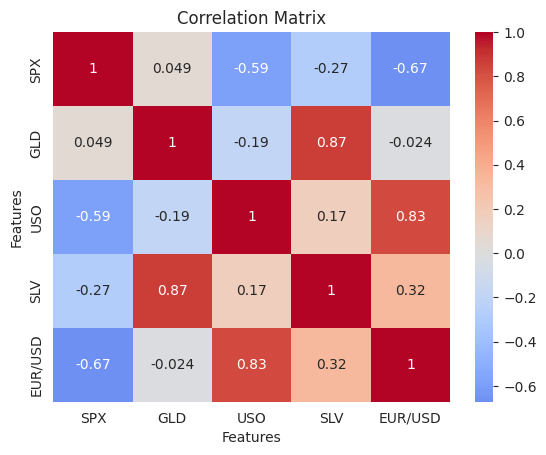

In [7]:
#correlation matrix
correlation =  dt.drop(columns=['Date']).corr()
sn.heatmap(correlation, cmap='coolwarm', center=0, annot=True)

plt.title('Correlation Matrix')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [8]:
# reset the index to date column
dt.set_index("Date", inplace=True)

In [9]:
# drop SlV column (SLV and GLD are strongly correlated)

dt.drop("SLV", axis=1, inplace=True)

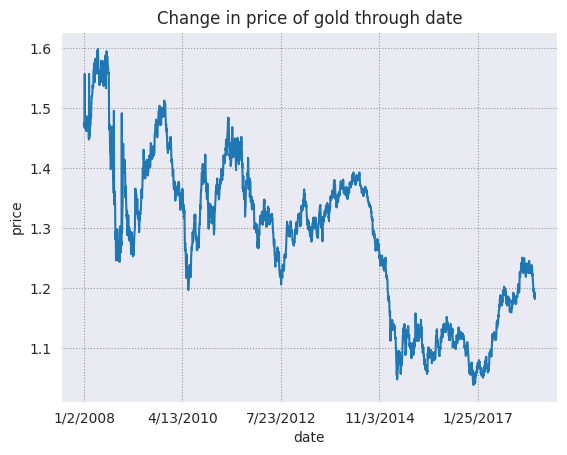

In [10]:
# plot price of gold for each increasing day
dt["EUR/USD"].plot()
plt.title("Change in price of gold through date")
plt.xlabel("date")
plt.ylabel("price")
plt.show()


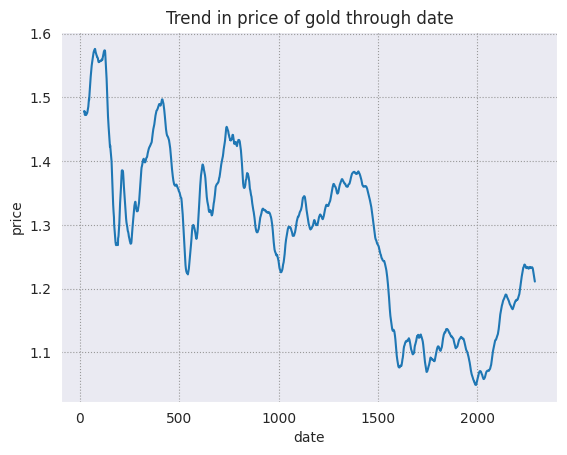

In [11]:
# apply rolling mean with window size of 3
dt["price_trend"] = dt["EUR/USD"]\
    .rolling(window=20).mean()

# reset the index to date column
dt.reset_index("Date", inplace=True)

# since we have used rolling method
# for 20 rows first 2 rows will be NAN
dt["price_trend"].loc[20:].plot()

# set title of the chart
plt.title("Trend in price of gold through date")

# set x_label of the plot
plt.xlabel("date")
plt.ylabel("price")
plt.show()



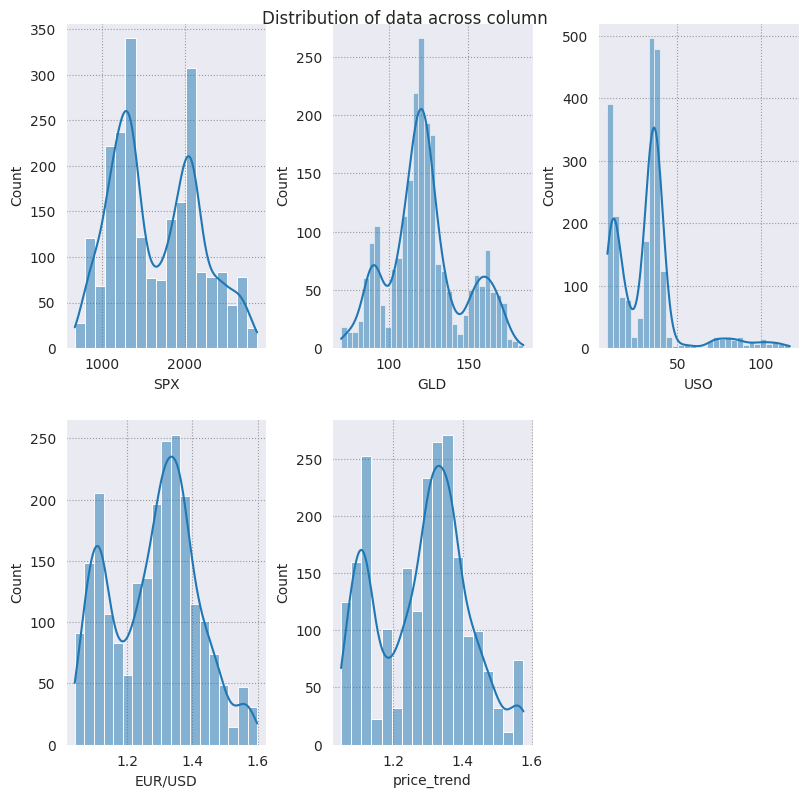

In [12]:
fig = plt.figure(figsize=(8, 8))

# suptitle of the graph
fig.suptitle('Distribution of data across column')
temp = dt.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
    plt.subplot(2, 3, i+1)
    sn.histplot(data=dt, x=item, kde=True)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()


In [13]:
# skewness along the index axis
print(dt.drop("Date", axis=1).skew(axis=0, skipna=True))

SPX            0.300362
GLD            0.334138
USO            1.699331
EUR/USD       -0.005292
price_trend   -0.029588
dtype: float64


In [14]:
# apply saquare root transformation
# on the skewed dataset
dt["USO"] = dt["USO"]\
    .apply(lambda x: np.sqrt(x))

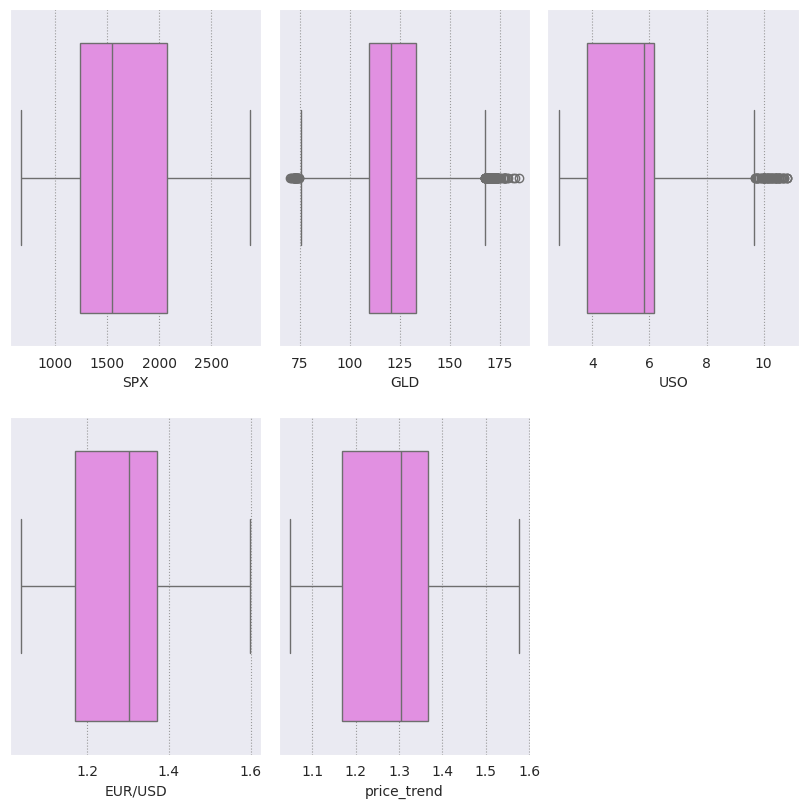

In [15]:
fig = plt.figure(figsize=(8, 8))
temp = dt.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
    plt.subplot(2, 3, i+1)
    sn.boxplot(data=dt, x=item, color='violet')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()


In [16]:
def outlier_removal(column):
    # Capping the outlier rows with Percentiles
    upper_limit = column.quantile(.95)
    # set upper limit to 95percentile
    lower_limit = column.quantile(.05)
    # set lower limit to 5 percentile
    column.loc[(column > upper_limit)] = upper_limit
    column.loc[(column < lower_limit)] = lower_limit
    return column


In [17]:
# Normalize outliers in columns except Date

dt[['SPX', 'GLD', 'USO', 'EUR/USD']] = \
    dt[['SPX', 'GLD', 'USO', 'EUR/USD']].apply(outlier_removal)


In [18]:
# select the features and target variable
X = dt.drop(['Date', 'EUR/USD'], axis=1)

y = dt['EUR/USD']
# dividing dataset in to train test
x_train, x_test,\
    y_train, y_test = train_test_split(X, y, test_size=0.2)


In [19]:
# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit the StandardScaler on the training dataset
scaler.fit(x_train)

# Transform the training dataset
# using the StandardScaler
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [20]:
# Impute missing values using SimpleImputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean') # Replace NaNs with the mean of each column

# Fit and transform the imputer on the scaled training data
x_train_scaled = imputer.fit_transform(x_train_scaled)

# Transform the scaled test data using the trained imputer
x_test_scaled = imputer.transform(x_test_scaled)

# Create a PolynomialFeatures object of degree 2
poly = PolynomialFeatures(degree=2)

# Create a Lasso object
lasso = Lasso()

# Define a dictionary of parameter
#values to search over
param_grid = {'lasso__alpha': [1e-4, 1e-3, 1e-2,
                            1e-1, 1, 5, 10,
                            20, 30, 40]}

# Create a pipeline that first applies
# polynomial features and then applies Lasso regression
pipeline = make_pipeline(poly, lasso)

# Create a GridSearchCV object with
#the pipeline and parameter grid
lasso_grid_search = GridSearchCV(pipeline,
                                param_grid,
                                scoring='r2', cv=3)

# Fit the GridSearchCV object to the training data
lasso_grid_search.fit(x_train_scaled, y_train)

# Predict the target variable using
# the fitted model and the test data
y_pred = lasso_grid_search.predict(x_train_scaled)

# Compute the R-squared of the fitted model on the train data
r2 = r2_score(y_train, y_pred)

# Print the R-squared
print("R-squared: ", r2)

# Print the best parameter values and score
print('Best parameter values: ',
    lasso_grid_search.best_params_)
print('Best score: ',
    lasso_grid_search.best_score_)


R-squared:  0.9661748409221054
Best parameter values:  {'lasso__alpha': 0.0001}
Best score:  0.9653801708403872


In [21]:
# Insiate param grid for which to search
param_grid = {'n_estimators': [50, 80, 100],
              'max_depth': [3, 5, 7]}

# create instance of the Randomforest regressor
rf = RandomForestRegressor()

# Define Girdsearch with random forest
# object parameter grid scoring and cv
rf_grid_search = GridSearchCV(rf, param_grid, scoring='r2', cv=2)

# Fit the GridSearchCV object to the training data

rf_grid_search.fit(x_train_scaled, y_train)

# Print the best parameter values and score
print('Best parameter values: ', rf_grid_search.best_params_)
print('Best score: ', rf_grid_search.best_score_)


Best parameter values:  {'max_depth': 7, 'n_estimators': 100}
Best score:  0.974325502195706


In [22]:
# Compute the R-squared of the
# fitted model on the test data
r2 = r2_score(y_test,
              rf_grid_search.predict(x_test_scaled))

# Print the R-squared
print("R-squared:", r2)


R-squared: 0.978669604290081


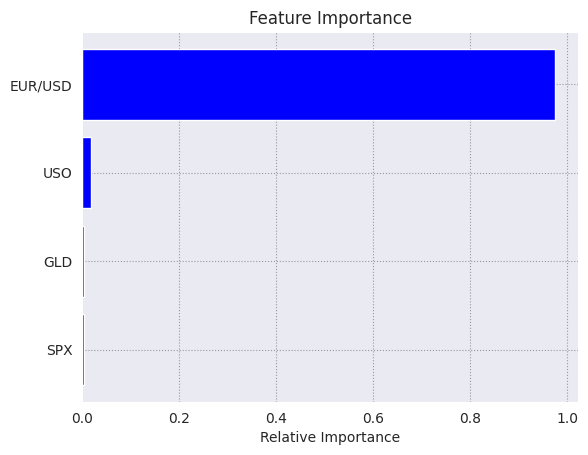

In [23]:
features = dt.drop("Date", axis=1).columns

# store the importance of the feature
importances = rf_grid_search.best_estimator_.\
    feature_importances_


indices = np.argsort(importances)

# title of the graph
plt.title('Feature Importance')

plt.barh(range(len(indices)),
         importances[indices],
         color='blue',
         align='center')

# plot bar chart
plt.yticks(range(len(indices)),
           [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [24]:
# Create an instance of the XGBRegressor model
model_xgb = XGBRegressor()

# Fit the model to the training data
model_xgb.fit(x_train_scaled, y_train)

# Print the R-squared score on the training data
print("Xgboost Accuracy =", r2_score(
    y_train, model_xgb.predict(x_train_scaled)))


Xgboost Accuracy = 0.9994691537240752


In [25]:
# Print the R-squared score on the test data
print("Xgboost Accuracy on test data =",
      r2_score(y_test,
               model_xgb.predict(x_test_scaled)))

Xgboost Accuracy on test data = 0.9870203754488595


In [26]:
import eli5 as eli
# weight of variables in xgboost model
# Get the names of the features
feature_names = x_train.columns.tolist()

# Explain the weights of the features using ELI5
eli.explain_weights(model_xgb, feature_names=feature_names)


Weight,Feature
0.9555,price_trend
0.0299,USO
0.0085,GLD
0.0061,SPX


In [27]:
# dump model using pickle library
import pickle

# dump model in file model.pkl
pickle.dump(model_xgb, open('model.pkl', 'wb'))